In [3]:
import requests
import json
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import datetime as dt
from pypfopt import EfficientFrontier # nb pypfopt is shorthand for the package pyportfolioopt
from pypfopt import risk_models
from pypfopt import expected_returns

In [3]:
%%time 

url = "https://api.coincap.io/v2/assets"

# N.B. here adampt the params dict to only request what you need
payload={'limit': '100'}
headers = {}

response_assets = requests.request("GET", url, params=payload, headers=headers)
assets_json = response_assets.json()

CPU times: user 26.3 ms, sys: 9.84 ms, total: 36.1 ms
Wall time: 448 ms


In [5]:
assets_json

{'data': [{'id': 'bitcoin',
   'rank': '1',
   'symbol': 'BTC',
   'name': 'Bitcoin',
   'supply': '19043206.0000000000000000',
   'maxSupply': '21000000.0000000000000000',
   'marketCapUsd': '559671576179.4286020109975666',
   'volumeUsd24Hr': '12300334331.2161902589380938',
   'priceUsd': '29389.5668712205603411',
   'changePercent24Hr': '-3.7819471030984226',
   'vwap24Hr': '29948.1083774993105494',
   'explorer': 'https://blockchain.info/'},
  {'id': 'ethereum',
   'rank': '2',
   'symbol': 'ETH',
   'name': 'Ethereum',
   'supply': '120827260.3740000000000000',
   'maxSupply': None,
   'marketCapUsd': '240605400680.7632948695057892',
   'volumeUsd24Hr': '7449769765.8746617907691925',
   'priceUsd': '1991.3171906406771582',
   'changePercent24Hr': '-5.0740933403072908',
   'vwap24Hr': '2046.6983562141423353',
   'explorer': 'https://etherscan.io/'},
  {'id': 'tether',
   'rank': '3',
   'symbol': 'USDT',
   'name': 'Tether',
   'supply': '74209002354.8673000000000000',
   'maxSuppl

In [6]:
ids_list = []
for dict in assets_json['data']:
    ids_list.append(dict['id'])

In [7]:
ids_list

['bitcoin',
 'ethereum',
 'tether',
 'usd-coin',
 'binance-coin',
 'xrp',
 'binance-usd',
 'cardano',
 'solana',
 'dogecoin']

In [8]:
symbol_list = []
for dict in assets_json['data']:
    symbol_list.append(dict['symbol'])
symbol_list

['BTC', 'ETH', 'USDT', 'USDC', 'BNB', 'XRP', 'BUSD', 'ADA', 'SOL', 'DOGE']

In [9]:
%%time
url = "http://api.coincap.io/v2/assets/{}/history?interval=d1"

payload={}
headers = {}

histories_dict = {}
for id in ids_list:
    response_histories = requests.request("GET", url.format(id), headers=headers, data=payload)
    histories_json = response_histories.json()
    histories_dict[id] = histories_json['data']

CPU times: user 337 ms, sys: 51.9 ms, total: 389 ms
Wall time: 6.65 s


In [10]:
for id in ids_list:
    print(id +": {}".format(len(histories_dict[id])))

bitcoin: 364
ethereum: 364
tether: 364
usd-coin: 364
binance-coin: 364
xrp: 364
binance-usd: 364
cardano: 364
solana: 364
dogecoin: 364


In [11]:
dt.datetime.strptime(histories_dict['bitcoin'][0]['date'][0:10], '%Y-%m-%d')

datetime.datetime(2021, 5, 19, 0, 0)

In [12]:
def date_conv(date):
    return dt.datetime.strptime(date, '%Y-%m-%d')
price_histories_df = pd.DataFrame(columns=['coin','date','price'])
return_histories_df = pd.DataFrame(columns=['coin','date','price'])
for id in ids_list:
    price=[]
    date=[]
    for observation in histories_dict[id]:
        date.append(date_conv(observation['date'][0:10]))
        #date.append(observation['time'])
        price.append(float(observation['priceUsd']))
    price_df = pd.DataFrame({"coin": id, "date":date, "price": price})
    price_histories_df = pd.concat([price_histories_df, price_df])
    returns = [float(b) / float(a) for b,a in zip(price[1:], price[:-1])]
    returns_df = pd.DataFrame({"coin": id, "date":date[1:], "price": returns})
    return_histories_df = pd.concat([return_histories_df, returns_df])

In [13]:
price=[]
date=[]
for observation in histories_dict['bitcoin']:
    date.append(observation['date'][0:10])
    #date.append(observation['time'])
    price.append(float(observation['priceUsd']))
price_df = pd.DataFrame({"coin": 'bitcoin', "date":date, "price": price})
returns = [float(b) / float(a) for b,a in zip(price[1:], price[:-1])]
returns_df = pd.DataFrame({"coin": 'bitcoin', "date":date[1:], "price": returns})

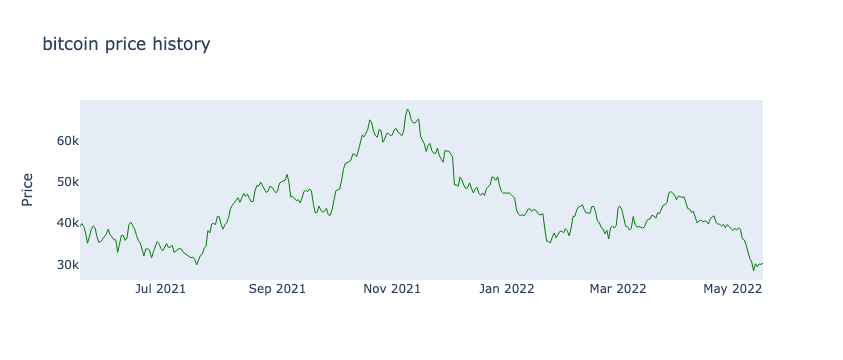

In [14]:
fig = go.Figure(data=
                [
                go.Scatter(x=date, y=price,
                            line={'color':'green', 'width':1},name='bitcoin')])

fig.update_layout(go.Layout(xaxis = {'showgrid': False},
                  yaxis = {'showgrid': False}),
                  title=f'bitcoin price history',
                    yaxis_title=f'Price',
                    xaxis_rangeslider_visible=False)

# Price histories

In [16]:
price_histories_df

coin                 date         price
0     bitcoin  2021-05-19 00:00:00   39147.86381
1     bitcoin  2021-05-20 00:00:00  39865.225714
2     bitcoin  2021-05-21 00:00:00  39161.303117
3     bitcoin  2021-05-22 00:00:00  37543.682924
4     bitcoin  2021-05-23 00:00:00  35095.165825
..        ...                  ...           ...
359  dogecoin  2022-05-13 00:00:00      0.090304
360  dogecoin  2022-05-14 00:00:00      0.088266
361  dogecoin  2022-05-15 00:00:00      0.089077
362  dogecoin  2022-05-16 00:00:00      0.088213
363  dogecoin  2022-05-17 00:00:00      0.089524

[3640 rows x 3 columns]

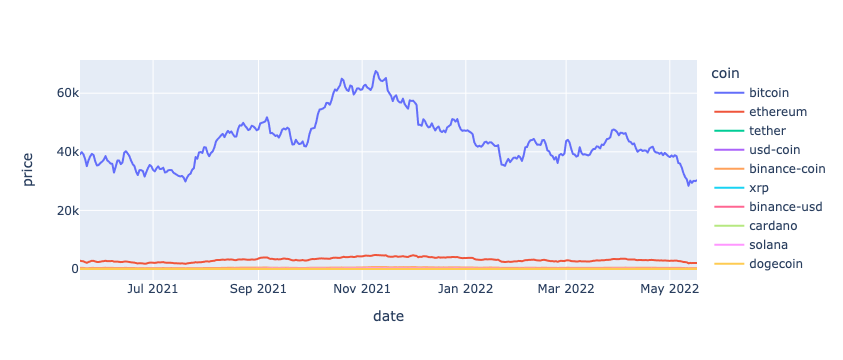

In [15]:
fig = px.line(price_histories_df, x="date", y="price", color="coin")
fig.show()

# Return histories

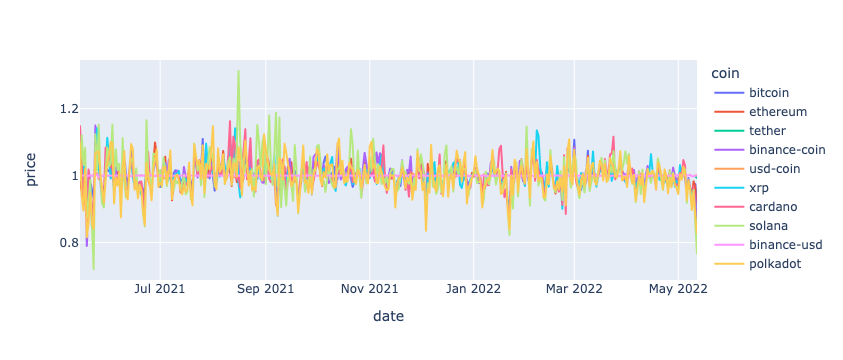

In [15]:
fig = px.line(return_histories_df, x="date", y="price", color="coin")
fig.show()

# Rebased price history

In [16]:
start_date = dt.date.today()-dt.timedelta(350)

In [17]:
start_date

datetime.date(2021, 5, 28)

In [18]:
return_histories_df.head()

coin                 date     price
0  bitcoin  2021-05-15 00:00:00  0.973682
1  bitcoin  2021-05-16 00:00:00  0.977108
2  bitcoin  2021-05-17 00:00:00  0.928394
3  bitcoin  2021-05-18 00:00:00  0.996702
4  bitcoin  2021-05-19 00:00:00   0.88482

In [19]:
bitcoin_rebase = return_histories_df[(return_histories_df['date']>=pd.Timestamp(start_date)) 
                    & (return_histories_df['coin']=='bitcoin')]

In [20]:
bitcoin_rebase.head()

coin                 date     price
13  bitcoin  2021-05-28 00:00:00  0.943743
14  bitcoin  2021-05-29 00:00:00  0.962769
15  bitcoin  2021-05-30 00:00:00  1.006038
16  bitcoin  2021-05-31 00:00:00   1.01863
17  bitcoin  2021-06-01 00:00:00  1.012513

In [21]:
bitcoin_rebase['price'].iloc[0]=1

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/429660237.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
rebased_price=[1]
for i in range(1,len(bitcoin_rebase)):
    rebased_price.append(bitcoin_rebase['price'].iloc[i]*rebased_price[i-1])

In [23]:
bitcoin_rebase['rebased_price']=rebased_price

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/1561476697.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
start_date = dt.date.today()-dt.timedelta(360)
rebased_prices_df = pd.DataFrame(columns=['coin','date','price','rebased_price'])
for id in ids_list:
    temp_rebase_df = return_histories_df[(return_histories_df['date']>=pd.Timestamp(start_date)) 
                                         & (return_histories_df['coin']==id)]
    rebased_price=[1]
    for i in range(1,len(temp_rebase_df)):
        rebased_price.append(temp_rebase_df['price'].iloc[i]*rebased_price[i-1])
    temp_rebase_df['rebased_price']=rebased_price
    rebased_prices_df = pd.concat([rebased_prices_df, temp_rebase_df])
    
    

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/1122556680.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/1122556680.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/1122556680.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [1]:
rebased_prices_df

NameError: name 'rebased_prices_df' is not defined

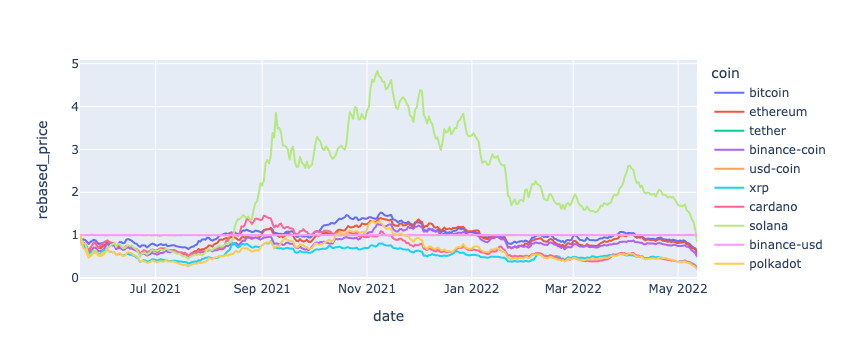

In [25]:
fig = px.line(rebased_prices_df, x="date", y="rebased_price", color="coin")
fig.show()

next up:
- create streamlit coin viewer
- loads up the top 10 coin's logos
- loads up the price histories for those coins
- on click allows you to add coins to graphs - just rebased for now.
- add: max drawdown, vol, sharpe ratio, returns (absolute and annualised)


Then;
- create portfolio viewer

In [26]:
return_histories_df['coin'].value_counts()


bitcoin         363
ethereum        363
tether          363
binance-coin    363
usd-coin        363
xrp             363
cardano         363
solana          363
binance-usd     363
polkadot        363
Name: coin, dtype: int64

In [27]:
ids_list

['bitcoin',
 'ethereum',
 'tether',
 'binance-coin',
 'usd-coin',
 'xrp',
 'cardano',
 'solana',
 'binance-usd',
 'polkadot']

In [28]:
weights = [0.1]*10

In [29]:
portfolio_dict={ids_list[i]:weights[i] for i in range(len(weights))}

In [30]:
portfolio_dict

{'bitcoin': 0.1,
 'ethereum': 0.1,
 'tether': 0.1,
 'binance-coin': 0.1,
 'usd-coin': 0.1,
 'xrp': 0.1,
 'cardano': 0.1,
 'solana': 0.1,
 'binance-usd': 0.1,
 'polkadot': 0.1}

In [31]:
start_date = dt.date.today()-dt.timedelta(360)
weighted_prices_df = pd.DataFrame(columns=['coin','date','price','weighted_price'])
for id in ids_list:
    temp_weight_df = return_histories_df[(return_histories_df['date']>=pd.Timestamp(start_date)) 
                                         & (return_histories_df['coin']==id)]
    weighted_price=[portfolio_dict[id]]
    for i in range(1,len(temp_weight_df)):
        weighted_price.append(temp_weight_df['price'].iloc[i]*weighted_price[i-1])
    temp_weight_df['weighted_price']=weighted_price
    weighted_prices_df = pd.concat([weighted_prices_df, temp_weight_df])

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/3327992111.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/3327992111.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_44311/3327992111.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [32]:
date_list = [start_date + dt.timedelta(days=x) for x in range(360)]

In [33]:
port_returns=[]
for date in date_list:
    port_returns.append(weighted_prices_df['weighted_price'][weighted_prices_df['date']==pd.Timestamp(date)].sum())

In [34]:
port_returns_df = pd.DataFrame({'date':date_list, 'price': port_returns})

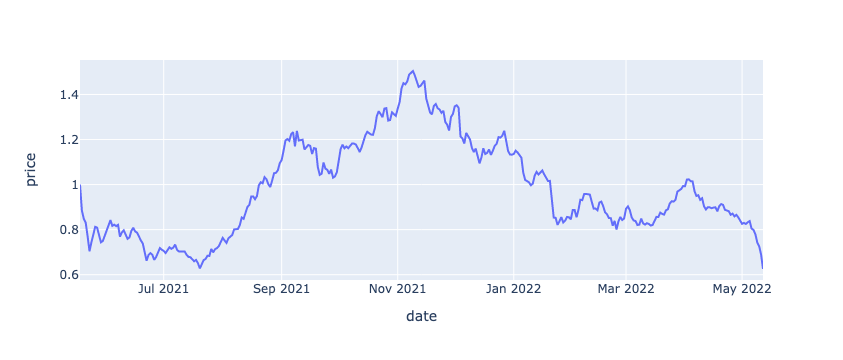

In [35]:
fig = px.line(port_returns_df, x="date", y="price")
fig.show()

In [36]:
try:
    from PIL import Image
except ImportError:
    import Image
import numpy as np


In [37]:
id_symbol_map = {}
for dict in assets_json['data']:
    id_symbol_map[dict['id']]=dict['symbol']

In [38]:
def create_grid(top_left, bottom_right):
    num_rows=3
    num_cols=7
    col_positions = np.linspace(top_left[0], bottom_right[0], num=num_cols)
    row_positions = np.linspace(top_left[1], bottom_right[1], num=num_rows)
    return [(int(col_positions[i]),int(row_positions[j])) for j in range(num_rows) for  i in range(num_cols)]

In [39]:
top_left=[300,300]
bottom_right=[650, 450]
grid = create_grid(top_left, bottom_right)

In [40]:
len(grid)

21

In [41]:
def add_logo(background, symbol, position, size=(70,70)):
    bg = Image.open(background)
    fg = Image.open("logos/{}.png".format(symbol))

    bg = bg.convert("RGBA")
    fg = fg.convert("RGBA")

    # Resize logo
    fg_resized = fg.resize(size)

    # Overlay logo onto background at position
    bg.paste(fg_resized,box=position,mask=fg_resized)

    # Save result
    bg.save(background)
    
    

In [42]:
id_symbol_map

{'bitcoin': 'BTC',
 'ethereum': 'ETH',
 'tether': 'USDT',
 'binance-coin': 'BNB',
 'usd-coin': 'USDC',
 'xrp': 'XRP',
 'cardano': 'ADA',
 'solana': 'SOL',
 'binance-usd': 'BUSD',
 'polkadot': 'DOT'}

In [43]:
port_returns_df.head()

date     price
0  2021-05-18  1.000000
1  2021-05-19  0.884728
2  2021-05-20  0.848178
3  2021-05-21  0.831057
4  2021-05-22  0.770539

In [44]:
def absolute_return(daily_prices):
    'a function to calculate the absolute return given a daily price series'
    abs_rtn = ((daily_prices.iloc[-1]/daily_prices[0])-1)*100
    return abs_rtn

def annual_return(daily_prices):
    'a function to calculate the annualised return given a daily price series'
    abs_rtn = absolute_return(daily_prices)
    annual_rnt = (pow((abs_rtn/100)+1, 365/len(daily_prices))-1)*100
    return annual_rnt


    

In [45]:
absolute_return(port_returns_df['price'])

-37.469782146637066

In [46]:
annual_return(port_returns_df['price'])

-37.876222209781055

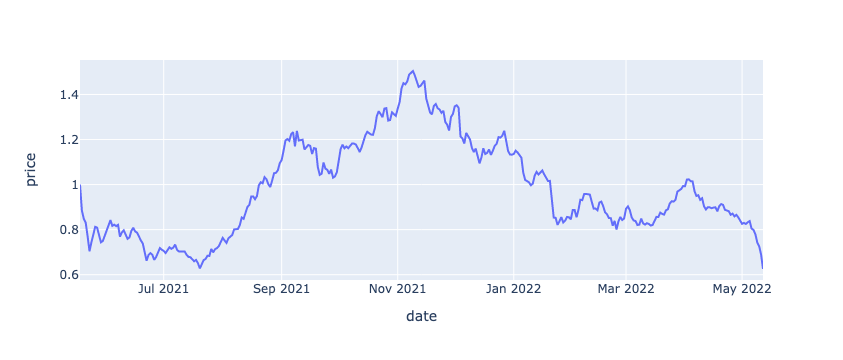

In [47]:
fig = px.line(port_returns_df, x="date", y="price")
fig.show()

In [48]:
max(port_returns_df['price'])

1.5042064746683073

In [49]:
min(port_returns_df[port_returns_df['date']>=pd.Timestamp('2021-12-27')]['price'])

/usr/local/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



0.6253021785336292

In [50]:
max_dd=max(port_returns_df['price'])-min(port_returns_df[port_returns_df['date']>=pd.Timestamp('2021-12-27')]['price'])

In [51]:
max_dd =max_dd /max(port_returns_df['price'])

In [52]:
max_dd

0.5842976419367463

In [53]:
type(port_returns_df['price'].values)

numpy.ndarray

In [54]:
port_returns_df['price']

0      1.000000
1      0.884728
2      0.848178
3      0.831057
4      0.770539
         ...   
355    0.779366
356    0.743019
357    0.725969
358    0.689412
359    0.625302
Name: price, Length: 360, dtype: float64

In [55]:
end_idx = np.argmax(np.maximum.accumulate(port_returns_df['price'].values) - port_returns_df['price'].values) # end of the period
start_idx = np.argmax(port_returns_df['price'].values[:end_idx]) # start of period

In [56]:
(port_returns_df['price'].values[start_idx]-port_returns_df['price'].values[end_idx])/port_returns_df['price'].values[start_idx]

0.5842976419367463

In [57]:
def max_drawdown(prices):
    '''
    A function to calculate the max drawdown for a given price series "daily_prices"
    as well as the index of the start of the max drawdown period, "start_idx"
    and the index of end of the max drawdwon period, "end index"
    '''
    if type(prices)==type(pd.Series(dtype='object')):
        prices = prices.values
    end_idx = np.argmax(np.maximum.accumulate(port_returns_df['price'].values) - port_returns_df['price'].values) # end of the period
    start_idx = np.argmax(port_returns_df['price'].values[:end_idx]) # start of period
    max_dd = (prices[start_idx]-prices[end_idx])/prices[start_idx]
    return max_dd, start_idx, end_idx

In [58]:
max_drawdown(port_returns_df['price'])

(0.5842976419367463, 175, 359)

In [59]:
def annual_vol(prices):
    prices.pct_change().std()*(365**0.5)

In [60]:
prices = port_returns_df['price']

In [61]:
prices.pct_change().std()*(365**0.5)

0.5060838732200098

In [62]:
def absolute_return(prices):
  'a function to calculate the absolute return given a daily price series'
  abs_rtn = ((prices.iloc[-1]/prices[0])-1)
  return abs_rtn

def annual_return(prices):
  'a function to calculate the annualised return given a daily price series'
  abs_rtn = absolute_return(prices)
  annual_rnt = (pow((abs_rtn/100)+1, 365/len(prices))-1)*100
  return annual_rnt

def max_drawdown(prices):
  '''
  A function to calculate the max drawdown for a given price series "prices"
  as well as the index of the start of the max drawdown period, "start_idx"
  and the index of end of the max drawdwon period, "end index"
  '''
  if type(prices)==type(pd.Series(dtype='object')):
      prices = prices.values
  end_idx = np.argmax(np.maximum.accumulate(prices) - prices) # end of the period
  start_idx = np.argmax(prices[:end_idx]) # start of period
  max_dd = (prices[start_idx]-prices[end_idx])/prices[start_idx]
  return max_dd, start_idx, end_idx

def annual_vol(prices):
  '''
  A function to calculate the annuaised volatility of a price series assuming
  cryptos trade 365 days a year
  '''
  return prices.pct_change().std()*(365**0.5)

In [63]:
prices= port_returns_df['price']
print(annual_return(prices), absolute_return(prices), annual_vol(prices), max_drawdown(prices))

-0.3798920603696798 -0.37469782146637065 0.5060838732200098 (0.5842976419367463, 175, 359)


In [64]:
max_dd, start_idx, end_idx = max_drawdown(port_returns_df['price'])

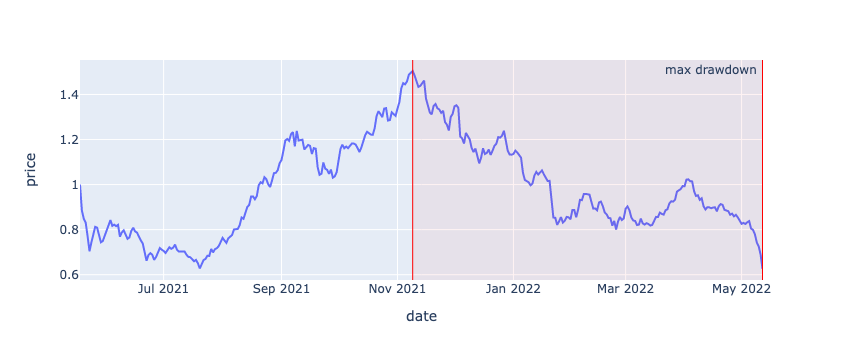

In [65]:
start_dt = port_returns_df['date'].iloc[start_idx]
end_dt = port_returns_df['date'].iloc[end_idx]
fig = px.line(port_returns_df, x="date", y="price")
fig.add_vline(x=start_dt, line_width=1, line_color="red")
fig.add_vline(x=end_dt, line_width=1, line_color="red")
fig.add_vrect(x0=start_dt, x1=end_dt, line_width=0, fillcolor="red", opacity=0.05, annotation_text="max drawdown ")
fig.show()

In [66]:
metrics_dict= {'annual_return' : "Return (annualised)", 'absolute_return': "Return",
 'annual_vol': 'Annual volatiloty', 'max_drawdown': 'Max loss in period'}

def write_metrics(prices, *metrics):
    for metric in metrics:
        if metric.__name__ == 'max_drawdown':
            print(metrics_dict[metric.__name__] +': {:.2%}'.format(metric(prices)[0]))
        else:
            print(metrics_dict[metric.__name__] +': {:.2%}'.format(metric(prices)))

In [67]:
write_metrics(prices, annual_return, absolute_return, annual_vol, max_drawdown)

Return (annualised): -37.99%
Return: -37.47%
Annual volatiloty: 50.61%
Max loss in period: 58.43%


In [70]:
metrics_dict= {annual_return, absolute_return, annual_vol, max_drawdown}

In [138]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [139]:
date2 = []
for observation in histories_dict[ids_list[0]]:
        date2.append(date_conv(observation['date'][0:10]))
wide_prices_df = pd.DataFrame(index=date2)
for id in ids_list:
    price=[]
    for observation in histories_dict[id]:
        price.append(float(observation['priceUsd']))
    wide_prices_df[id]=price

In [140]:
wide_prices_df.head()

bitcoin     ethereum    tether  binance-coin  usd-coin  \
2021-05-14  50256.870089  3971.483844  1.001722    596.899510  1.001468   
2021-05-15  48934.226496  3903.410883  1.001386    587.094970  1.001881   
2021-05-16  47814.048570  3705.884760  1.001379    576.757833  1.002716   
2021-05-17  44390.265221  3392.873814  1.001662    524.228448  1.002724   
2021-05-18  44243.887792  3427.784701  1.001324    517.961918  1.001350   

                 xrp   cardano     solana  binance-usd   polkadot  
2021-05-14  1.385109  1.905062  42.285529     1.000565  42.526788  
2021-05-15  1.424324  2.187052  41.716003     1.000554  46.647836  
2021-05-16  1.518829  2.289533  46.757667     1.001086  43.881551  
2021-05-17  1.471747  2.116343  48.253216     1.000984  39.306578  
2021-05-18  1.569719  2.058689  52.271376     1.000477  40.142562

In [184]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(wide_prices_df)
S = risk_models.sample_cov(wide_prices_df)

from cvxpy.error import SolverError
from pypfopt.exceptions import InstantiationError

# Optimize for maximal Sharpe ratio

attempts=0
while attempts < 10:
    try:
        ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
        ef.max_sharpe()
        print(attempts)
        break
    #except SolverError as e:
        #attempts += 1
        #print("SolverError %d: %s" % (e.args[0], e.args[1]))
    #except InstantiationError as er:
        #attempts += 1
    except Exception as e:
        attempts += 1
#raw_weights = ef.min_volatility()
try:
    cleaned_weights = ef.clean_weights()
    print(cleaned_weights)
    ef.portfolio_performance(verbose=True)
except Exception as e:
    print("Could not find optimal solution, try changing optimisation constraints or investment set")

0
OrderedDict([('bitcoin', -0.00027), ('ethereum', 0.32348), ('tether', -0.14998), ('binance-coin', 0.01765), ('usd-coin', 1.0), ('xrp', -0.54611), ('cardano', -0.77468), ('solana', 1.0), ('binance-usd', 1.0), ('polkadot', -0.87009)])
Expected annual return: 130.6%
Annual volatility: 97.9%
Sharpe Ratio: 1.31


In [185]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(wide_prices_df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'usd-coin': 2981, 'solana': 66, 'binance-usd': 2985, 'binance-coin': 1, 'polkadot': -1031, 'cardano': -16546, 'xrp': -14335, 'tether': -1510}
Funds remaining: $788.99


In [4]:
histories_df= pd.read_csv('histories.csv')
histories_df['date'] = list(map(date_conv,histories_df['date']))
histories_df = histories_df.set_index('date')

NameError: name 'date_conv' is not defined

In [25]:
histories_df.head()

bitcoin    ethereum    tether  usd-coin  binance-coin  \
date                                                                    
2017-05-20  1988.961436  124.671578  0.989347       NaN      0.008740   
2017-05-21  2041.043206  133.124882  0.993468       NaN           NaN   
2017-05-22  2132.615875  162.394661  0.994056       NaN      0.009597   
2017-05-23  2192.000968  162.851097  0.994256       NaN           NaN   
2017-05-24  2357.398184  185.628320  0.999779       NaN      0.010701   

                 xrp  binance-usd  cardano  solana  dogecoin  ...  kava  \
date                                                          ...         
2017-05-20  0.335994          NaN      NaN     NaN  0.001577  ...   NaN   
2017-05-21  0.340759          NaN      NaN     NaN  0.002355  ...   NaN   
2017-05-22  0.306679          NaN      NaN     NaN  0.002995  ...   NaN   
2017-05-23  0.314020          NaN      NaN     NaN  0.003343  ...   NaN   
2017-05-24  0.315158          NaN      NaN     NaN  0.003535  ...   NaN   

            kadena  lido-dao  holo  gatetoken  fei-protocol  kyber-network  \
date                                                                         
2017-05-20     NaN       NaN   NaN        NaN           NaN            NaN   
2017-05-21     NaN       NaN   NaN        NaN           NaN            NaN   
2017-05-22     NaN       NaN   NaN        NaN           NaN            NaN   
2017-05-23     NaN       NaN   NaN        NaN           NaN            NaN   
2017-05-24     NaN       NaN   NaN        NaN           NaN            NaN   

                qtum  bancor  1inch  
date                                 
2017-05-20       NaN     NaN    NaN  
2017-05-21       NaN     NaN    NaN  
2017-05-22       NaN     NaN    NaN  
2017-05-23  6.095773     NaN    NaN  
2017-05-24  7.854462     NaN    NaN  

[5 rows x 100 columns]

In [31]:
from datetime import date, timedelta
start_port_date = date.today() - timedelta(365)
start_analysis_date = start_port_date - timedelta(365)
investment_cols = ['bitcoin', 'ethereum', 'tether', 'usd-coin', 'binance-coin', 'xrp', 'cardano', 'solana', 'binance-usd', 'polkadot']

In [32]:
histories_df.shape

(1823, 100)

In [44]:
analysis_df = histories_df[start_analysis_date:start_port_date][investment_cols]

In [46]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(analysis_df)
S = risk_models.sample_cov(analysis_df)



# Optimize for maximal Sharpe ratio
attempts=0
while attempts < 10:
    try:
        ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        ef.max_sharpe()
        break
    except Exception as e:
        attempts += 1
#raw_weights = ef.min_volatility()
try:
    cleaned_weights = ef.clean_weights()
    print(cleaned_weights)
    ef.portfolio_performance(verbose=True)
except Exception as e:
    print("Could not find optimal solution, try changing optimisation constraints or investment set")

0
OrderedDict([('bitcoin', 0.0), ('ethereum', 0.0), ('tether', 0.0), ('usd-coin', 0.75201), ('binance-coin', 0.03029), ('xrp', 0.0), ('cardano', 0.12697), ('solana', 0.09073), ('binance-usd', 0.0), ('polkadot', 0.0)])
Expected annual return: 256.1%
Annual volatility: 18.4%
Sharpe Ratio: 13.80


In [48]:
assets_json['data']

[{'id': 'bitcoin',
  'rank': '1',
  'symbol': 'BTC',
  'name': 'Bitcoin',
  'supply': '19043206.0000000000000000',
  'maxSupply': '21000000.0000000000000000',
  'marketCapUsd': '559671576179.4286020109975666',
  'volumeUsd24Hr': '12300334331.2161902589380938',
  'priceUsd': '29389.5668712205603411',
  'changePercent24Hr': '-3.7819471030984226',
  'vwap24Hr': '29948.1083774993105494',
  'explorer': 'https://blockchain.info/'},
 {'id': 'ethereum',
  'rank': '2',
  'symbol': 'ETH',
  'name': 'Ethereum',
  'supply': '120827260.3740000000000000',
  'maxSupply': None,
  'marketCapUsd': '240605400680.7632948695057892',
  'volumeUsd24Hr': '7449769765.8746617907691925',
  'priceUsd': '1991.3171906406771582',
  'changePercent24Hr': '-5.0740933403072908',
  'vwap24Hr': '2046.6983562141423353',
  'explorer': 'https://etherscan.io/'},
 {'id': 'tether',
  'rank': '3',
  'symbol': 'USDT',
  'name': 'Tether',
  'supply': '74209002354.8673000000000000',
  'maxSupply': None,
  'marketCapUsd': '741946872

In [58]:
def ids_with_histories(histories_df, start_date, end_date):
  investment_df = histories_df[start_date:end_date]
  investment_df.dropna(axis=1, inplace=True) # drop cols with any NaN values
  return investment_df.columns

def uniform_weights_dict(ids_with_histories):
  weight = 1/len(ids_with_histories)
  uniform_weights_dict = {}
  for id in ids_with_histories:
    uniform_weights_dict[id] = weight
  return uniform_weights_dict


def markowitz_weights_dict(histories_df,start_port_date,ids_with_histories, analysis_days=365):
  start_analysis_date = start_port_date - timedelta(analysis_days)
  analysis_df = histories_df[start_analysis_date:start_port_date][ids_with_histories]

  # Calculate expected returns and sample covariance
  mu = expected_returns.mean_historical_return(analysis_df)
  S = risk_models.sample_cov(analysis_df)
  # Optimize for maximal Sharpe ratio
  attempts=0
  while attempts < 10:
    try:
      ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
      ef.max_sharpe()
      break
    except Exception as e:
      attempts += 1
  try:
    cleaned_weights = ef.clean_weights()
  except Exception as e:
    print("Could not find optimal solution, try changing optimisation constraints or investment set")
  return cleaned_weights


def gen_port_rtns(rebased_df, weights_dict):
  return rebased_df[list(weights_dict.keys())].dot(list(weights_dict.values()))

def gen_rebased_df(histories_df, ids_with_histories, start_date, end_date):
  returns_df = histories_df[ids_with_histories].pct_change(1)
  returns_df[start_date:start_date]=0
  return (1 + returns_df[start_date:end_date]).cumprod()

In [60]:
lookback_years = 5
start_date = date.today() - timedelta(365)
end_date = date.today()
ids_with_histories = ids_with_histories(histories_df,
  start_date, end_date)

/var/folders/ff/pmf9d5156jz_pr_s8ybs3x780000gn/T/ipykernel_23455/2151836904.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
uniform_weights_dict = uniform_weights_dict(ids_with_histories[:10])
markowitz_weights_dict = markowitz_weights_dict(histories_df,
  start_date ,ids_with_histories[:10], analysis_days=365)

In [62]:
rebased_df = gen_rebased_df(histories_df, ids_with_histories,
  start_date, end_date)

In [70]:

def gen_portfolio_returns(rebased_df, ids_with_histories,uniform_weights_dict,
  markowitz_weights_dict):
  uniform_returns = gen_port_rtns(rebased_df, uniform_weights_dict)
  uniform_returns.name = "Uniform"
  markowitz_returns = gen_port_rtns(rebased_df, markowitz_weights_dict)
  markowitz_returns.name = "Markowitz"
  port_returns = uniform_returns.to_frame().join(markowitz_returns)
  #port_returns = uniform_returns.merge(markowitz_returns, how='inner',  left_index=True, right_index=True)
  return port_returns

In [64]:
uniform_returns = gen_port_rtns(rebased_df, uniform_weights_dict)

In [65]:
uniform_returns.head()

date
2021-05-24    1.000000
2021-05-25    1.057165
2021-05-26    1.103699
2021-05-27    1.094057
2021-05-28    1.035221
dtype: float64

In [66]:
markowitz_returns = gen_port_rtns(rebased_df, markowitz_weights_dict)

In [67]:
markowitz_returns.head()

date
2021-05-24    1.000000
2021-05-25    1.015792
2021-05-26    1.018414
2021-05-27    1.016329
2021-05-28    1.005436
dtype: float64

In [68]:
port_returns = uniform_returns.to_frame().join(markowitz_returns)

ValueError: Other Series must have a name

In [71]:
port_returns = gen_portfolio_returns(rebased_df, ids_with_histories,uniform_weights_dict,
  markowitz_weights_dict)

In [75]:
port_returns

Uniform returns  Markowitz returns
date                                          
2021-05-24         1.000000           1.000000
2021-05-25         1.057165           1.015792
2021-05-26         1.103699           1.018414
2021-05-27         1.094057           1.016329
2021-05-28         1.035221           1.005436
...                     ...                ...
2022-05-13         0.858603           0.955128
2022-05-14         0.842769           0.952433
2022-05-15         0.863536           0.955837
2022-05-16         0.868936           0.958256
2022-05-17         0.878021           0.958963

[359 rows x 2 columns]

In [73]:
rebased_df[ids_with_histories]

bitcoin  ethereum    tether  usd-coin  binance-coin       xrp  \
date                                                                         
2021-05-24  1.000000  1.000000  1.000000  1.000000      1.000000  1.000000   
2021-05-25  1.035396  1.104084  1.004346  1.008332      1.117736  1.141806   
2021-05-26  1.059262  1.182178  0.998764  0.998087      1.211152  1.172456   
2021-05-27  1.047055  1.171337  0.998721  0.997785      1.209819  1.151604   
2021-05-28  0.988150  1.081310  0.998400  0.997946      1.118547  1.055065   
...              ...       ...       ...       ...           ...       ...   
2022-05-13  0.812658  0.876273  0.996467  0.997688      0.983592  0.501810   
2022-05-14  0.792168  0.853232  0.996625  0.997902      0.946064  0.487291   
2022-05-15  0.811404  0.872486  0.996529  0.997354      0.981676  0.494078   
2022-05-16  0.808139  0.862745  0.997260  0.998002      0.983805  0.491161   
2022-05-17  0.815820  0.874139  0.996455  0.997163      1.001658  0.499512   

            binance-usd   cardano    solana  dogecoin  ...   arweave  \
date                                                   ...             
2021-05-24     1.000000  1.000000  1.000000  1.000000  ...  1.000000   
2021-05-25     1.004241  1.067167  1.014951  1.073591  ...  1.015432   
2021-05-26     0.998892  1.180429  1.169596  1.066176  ...  1.157293   
2021-05-27     0.998899  1.166563  1.168901  1.029881  ...  1.159935   
2021-05-28     0.998932  1.070248  1.072628  0.970984  ...  1.011761   
...                 ...       ...       ...       ...  ...       ...   
2022-05-13     1.000345  0.381207  1.761244  0.274741  ...  1.048341   
2022-05-14     1.000207  0.359305  1.726351  0.268540  ...  0.995878   
2022-05-15     0.999817  0.377102  1.833901  0.271010  ...  1.188868   
2022-05-16     1.000452  0.390219  1.889197  0.268379  ...  1.205207   
2022-05-17     0.999466  0.394083  1.929546  0.272369  ...  1.119391   

            compound      kava      holo  gatetoken  fei-protocol  \
date                                                                
2021-05-24  1.000000  1.000000  1.000000   1.000000      1.000000   
2021-05-25  1.051228  1.084118  1.231873   1.106947      1.004524   
2021-05-26  1.142980  1.216742  1.508202   1.167414      1.001874   
2021-05-27  1.114319  1.253248  1.432746   1.155625      0.999451   
2021-05-28  1.007871  1.218521  1.269149   1.053198      0.994776   
...              ...       ...       ...        ...           ...   
2022-05-13  0.180244  0.694356  0.399718   1.318051      0.997489   
2022-05-14  0.178446  0.719093  0.383262   1.282516      0.989501   
2022-05-15  0.184456  0.802310  0.387249   1.293033      0.990860   
2022-05-16  0.179271  0.818549  0.380417   1.277471      0.983836   
2022-05-17  0.181975  0.858681  0.387170   1.304660      0.988791   

            kyber-network      qtum    bancor     1inch  
date                                                     
2021-05-24       1.000000  1.000000  1.000000  1.000000  
2021-05-25       1.037904  1.264676  1.078122  1.064602  
2021-05-26       1.153683  1.288506  1.173015  1.220068  
2021-05-27       1.178437  1.424998  1.192224  1.226486  
2021-05-28       1.072810  1.336266  1.095105  1.125980  
...                   ...       ...       ...       ...  
2022-05-13       0.995574  0.425182  0.341212  0.341313  
2022-05-14       0.985362  0.416411  0.330839  0.352400  
2022-05-15       1.002330  0.431056  0.341055  0.355338  
2022-05-16       0.974145  0.429696  0.340407  0.352632  
2022-05-17       1.136181  0.439168  0.345518  0.356643  

[359 rows x 85 columns]

In [78]:
import glob
from PIL import Image

In [82]:
for filename in glob.glob('logos/*.png'): #assuming all logos are png format
    im=Image.open(filename)
    im = im.convert('RGB')
    im.save('logos/{}.jpg'.format(filename[6:][:-4]))


In [83]:
def gen_all_returns(rebased_df, ids_with_histories,uniform_weights_dict,
  markowitz_weights_dict):
  '''
  A function to generate returns for all portfolios and all coins with full
  histories over the backtest period, rebased to the start of the backtest
  period.
  '''
  uniform_returns = gen_port_rtns(rebased_df, uniform_weights_dict)
  uniform_returns.name = "Uniform"
  markowitz_returns = gen_port_rtns(rebased_df, markowitz_weights_dict)
  markowitz_returns.name = "Markowitz"
  port_returns = uniform_returns.to_frame().join(markowitz_returns)
  return port_returns.join(rebased_df[ids_with_histories])

In [84]:
all_returns_df = gen_all_returns(rebased_df, ids_with_histories,uniform_weights_dict,
  markowitz_weights_dict)

In [85]:
all_returns_df.head()

Uniform  Markowitz   bitcoin  ethereum    tether  usd-coin  \
date                                                                      
2021-05-24  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000   
2021-05-25  1.057165   1.015792  1.035396  1.104084  1.004346  1.008332   
2021-05-26  1.103699   1.018414  1.059262  1.182178  0.998764  0.998087   
2021-05-27  1.094057   1.016329  1.047055  1.171337  0.998721  0.997785   
2021-05-28  1.035221   1.005436  0.988150  1.081310  0.998400  0.997946   

            binance-coin       xrp  binance-usd   cardano  ...   arweave  \
date                                                       ...             
2021-05-24      1.000000  1.000000     1.000000  1.000000  ...  1.000000   
2021-05-25      1.117736  1.141806     1.004241  1.067167  ...  1.015432   
2021-05-26      1.211152  1.172456     0.998892  1.180429  ...  1.157293   
2021-05-27      1.209819  1.151604     0.998899  1.166563  ...  1.159935   
2021-05-28      1.118547  1.055065     0.998932  1.070248  ...  1.011761   

            compound      kava      holo  gatetoken  fei-protocol  \
date                                                                
2021-05-24  1.000000  1.000000  1.000000   1.000000      1.000000   
2021-05-25  1.051228  1.084118  1.231873   1.106947      1.004524   
2021-05-26  1.142980  1.216742  1.508202   1.167414      1.001874   
2021-05-27  1.114319  1.253248  1.432746   1.155625      0.999451   
2021-05-28  1.007871  1.218521  1.269149   1.053198      0.994776   

            kyber-network      qtum    bancor     1inch  
date                                                     
2021-05-24       1.000000  1.000000  1.000000  1.000000  
2021-05-25       1.037904  1.264676  1.078122  1.064602  
2021-05-26       1.153683  1.288506  1.173015  1.220068  
2021-05-27       1.178437  1.424998  1.192224  1.226486  
2021-05-28       1.072810  1.336266  1.095105  1.125980  

[5 rows x 87 columns]

In [1]:
assets = all_returns_df.columns
performance_df = pd.DataFrame(index = assets)
performance_df['Type'] = ["Portfolio" if x in ['Uniform','Markowitz'] else "Coin" for x in assets]

NameError: name 'all_returns_df' is not defined

In [1]:
def absolute_return(prices):
  'a function to calculate the absolute return given a daily price series'
  abs_rtn = ((prices.iloc[-1]/prices[0])-1)
  return abs_rtn

def annual_return(prices):
  'a function to calculate the annualised return given a daily price series'
  abs_rtn = absolute_return(prices)
  annual_rnt = (pow((abs_rtn/100)+1, 365/len(prices))-1)*100
  return annual_rnt

def max_drawdown(prices):
  '''
  A function to calculate the max drawdown for a given price series "prices"
  as well as the index of the start of the max drawdown period, "start_idx"
  and the index of end of the max drawdwon period, "end index"
  '''
  if type(prices)==type(pd.Series(dtype='object')):
      prices = prices.values
  end_idx = np.argmax(np.maximum.accumulate(prices) - prices) # end of the period
  start_idx = np.argmax(prices[:end_idx]) # start of period
  max_dd = (prices[start_idx]-prices[end_idx])/prices[start_idx]
  return max_dd, start_idx, end_idx

def annual_vol(prices):
  '''
  A function to calculate the annuaised volatility of a price series assuming
  cryptos trade 365 days a year
  '''
  return prices.pct_change().std()*(365**0.5)

In [95]:
absolute_return(all_returns_df['Uniform'])

NameError: name 'absolute_return' is not defined